In [1]:
%conda install -yq pytorch-cpu -c pytorch

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Channels:
 - pytorch
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda/envs/notebook

  added / updated specs:
    - pytorch-cpu


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.12.14 |       hbcca054_0         153 KB  conda-forge
    certifi-2024.12.14         |     pyhd8ed1ab_0         158 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_1          17 KB  conda-forge
    gmpy2-2.1.5                |  py311h0f6cedb_3         198 KB  conda-forge
    libtorch-2.5.1             |cpu_generic_h1b269f6_6        51.0 MB  conda-forge
    mpc-1.3.1                  |       h24ddda3_1         114 KB  conda-forge
    mpmath-1.3.0  

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

from model import ConvNet

In [3]:
RUN_NUMBER = 0 # which channels selection to use
RUN_NAME = "batchnorm1"

MODEL_NAME = f"{RUN_NAME}_{RUN_NUMBER}"

# Channel configurations
channels = {
    0: [8, 16, 32],
    1: [16, 32, 64],
    2: [32, 64, 128],
    3: [64, 128, 256]
}

In [4]:
class WaveletDataset(Dataset):
    """Custom dataset class for loading wavelet data from files.

    This class is responsible for loading wavelet data and corresponding labels
    from the specified file paths. It supports splitting the data into training,
    validation, and test sets.

    Attributes:
        data_frame (np.ndarray): Array containing the wavelet data.
        labels (np.ndarray): Array containing the scaled labels.
    """    
    def __init__(self, data, mode, split=[0.8, 0.1, 0.1]):
        """
        Initialize the dataset.
        
        Args:
            data (DataFrame): the input and output data.
            mode (str): Mode to load ('train', 'val', or 'test').
            split (list): train, validation, and test split fractions.
        """
        ftrain, fval, ftest = [s/sum(split) for s in split]
        i_train = int(ftrain * len(data))
        i_val = int((ftrain + fval) * len(data))
        
        if mode == "train":
            df = data.iloc[:i_train]
        elif mode == "val":
            df = data.iloc[i_train:i_val]
        elif mode == "test":
            df = data.iloc[i_val:]
            
        self.features = df["wavelet"].values
        self.labels = df[["ebs", "exo", "flares", "rot"]].values

    def __len__(self):
        """Return the length of the dataset."""
        return len(self.labels)

    def __getitem__(self, idx):
        """Retrieve a single sample and its corresponding label.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the sample data (torch.Tensor) and the 
                   corresponding label (torch.Tensor).
        """
        X = self.features[idx].astype('float32')
        X = torch.unsqueeze(torch.tensor(X), 0)
        label = torch.tensor(self.labels[idx].astype('float32'))
        return X, label

In [5]:
cols = ["ebs", "exo", "flares", "rot"]
cat = pd.DataFrame([], columns=["TIC", "sector", *cols, "wavelet"])
cat.index.name = "filename"

for i, col in enumerate(cols):
    for s in os.listdir(f"wavelets/tess-{col}"):
        if s not in cat.index:
            wav = np.load(f"wavelets/tess-{col}/{s}")
            cat.loc[s] = [int(s[24:40]), int(s[19:23]), *([0]*len(cols)), wav/wav.max()]
        cat.loc[s, col] = 1

cat = cat.reset_index().set_index(["TIC", "sector"]).sort_index()
cat[cols] = cat[cols].div(cat[cols].sum(axis=1), axis=0)

In [6]:
np.random.seed(42)
mycat = cat.sample(frac=1)
tdata = torch.tensor(np.stack(WaveletDataset(mycat, "test").features), dtype=torch.float32).unsqueeze(1)

device = torch.device("cpu")
model = ConvNet(channels[RUN_NUMBER], k=3).to(device)
weights = model.load_state_dict(torch.load(f"{MODEL_NAME}/models/{MODEL_NAME}.pt", weights_only=True))

model.eval()
with torch.no_grad():
    embeddings = model.get_embeddings(tdata)

In [12]:
np.save("embeddings.npy", embeddings.numpy())

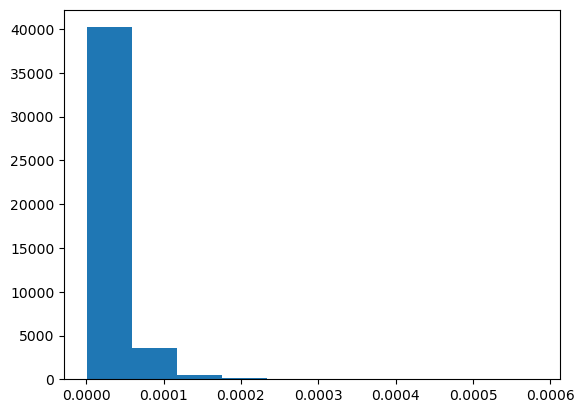

In [11]:
plt.hist(embeddings.flatten());